# Lab 1: Vanilla GAN (Goodfellow) — Skeleton

In [1]:
import torch, torchvision, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import math

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=128; z_dim=64; g_lr=d_lr=2e-4; num_epochs=3
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_ds=torchvision.datasets.MNIST('./data',True,download=True,transform=transform)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


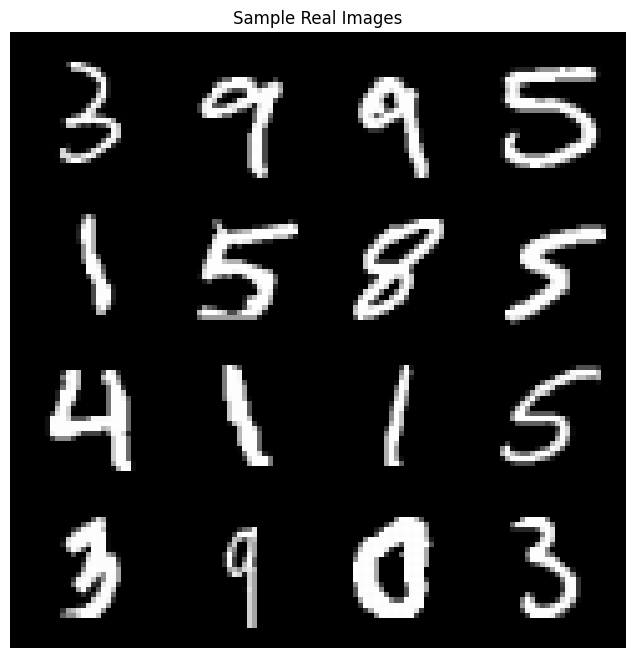

In [2]:
import matplotlib.pyplot as plt

real_images, _ = next(iter(train_loader))

image_grid = make_grid(real_images[:16], nrow=4, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(8, 8))
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Sample Real Images')
plt.show()

In [3]:
class Generator(nn.Module):
    def __init__(self,z_dim=64):
        super().__init__()
        # TODO: implement upsampling to 28x28 + Tanh
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)
        raise NotImplementedError()



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: downsample to 1 logit (no Sigmoid)
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),   # (B,64,14,14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # (B,128,7,7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )

    def forward(self, x):
        return self.net(x)


In [4]:
criterion=nn.BCEWithLogitsLoss()
G=Generator(z_dim).to(device); D=Discriminator().to(device)
opt_g=torch.optim.Adam(G.parameters(),lr=g_lr,betas=(0.5,0.999))
opt_d=torch.optim.Adam(D.parameters(),lr=d_lr,betas=(0.5,0.999))

In [5]:
@torch.no_grad()
def sample_grid(G,n=16):
    z=torch.randn(n,64,device=device).view(n,64,1,1)
    fake=G(z).cpu()
    return make_grid(fake,nrow=int(math.sqrt(n)),normalize=True,value_range=(-1,1))

In [6]:
def train_discriminator_step(real):
    # TODO: Goodfellow D loss with detach on fake
    opt_d.zero_grad()
    b = real.size(0)


    real_logits = D(real)
    real_labels = torch.ones(b, 1, device=device)
    real_loss = criterion(real_logits, real_labels)

    z = torch.randn(b, z_dim, 1, 1, device=device)
    fake = G(z).detach()
    fake_logits = D(fake)
    fake_labels = torch.zeros(b, 1, device=device)
    fake_loss = criterion(fake_logits, fake_labels)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    opt_d.step()
    return d_loss.item()

    raise NotImplementedError()

def train_generator_step(b):
    # TODO: non-saturating G loss
    opt_g.zero_grad()
    z = torch.randn(b, z_dim, 1, 1, device=device)
    fake = G(z)
    logits = D(fake)
    labels = torch.ones(b, 1, device=device)
    g_loss = criterion(logits, labels)
    g_loss.backward()
    opt_g.step()
    return g_loss.item()
    raise NotImplementedError()

In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt

for epoch in range(num_epochs):
    pbar=tqdm(train_loader)
    for real,_ in pbar:
        real=real.to(device)
        d=train_discriminator_step(real)
        g=train_generator_step(real.size(0))
        pbar.set_postfix(d_loss=d,g_loss=g)

100%|██████████| 469/469 [00:16<00:00, 29.20it/s, d_loss=0.578, g_loss=1.27]
